In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
# Set default plotly theme
pio.templates.default = 'plotly_white'

from src.utilities import Matrix

from src.observables import *

SUFFIX = '.npy'
OMEGA = 1  # Interaction Strength

HEAT = True
OBSERVABLES = ['Temperatures', 'Entropies', 'Mutual Information', 'Quantum Discord', 'Logarithmic Negativity', 'Heat Flux']

In [56]:
# Files utilities

def file_dims(filename):
    return int(filename.split('_')[-3][1:])


def file_time(filename):
    return int(filename.split('_')[-2][1:])


def file_timedelta(filename):
    return float(filename.split('_')[-1][2:])


def check_file_metadata(filename, d, dt):
    dims = file_dims(filename)
    timedelta = file_timedelta(filename)
    return dims == d and timedelta == dt


def get_all_files(state, key, observable):
    files = [file for file in os.listdir(f'../objects/saved{state}_{key}') if file.endswith(SUFFIX) and file.startswith(f'rho_{observable}')]
    return files

def get_last_file(startswith, dims, state, key):
    all_files = [f.removesuffix(SUFFIX) for f in os.listdir(f'../objects/saved/{state}_{key}') if f.startswith(f'{startswith}')]
    timedeltas = [file_timedelta(f) for f in all_files]
    max_times = {dt: max([file_time(f) for f in all_files if check_file_metadata(f, dims, dt)]) for dt in timedeltas}
    files = {dt: [f for f in all_files if check_file_metadata(f, dims, dt) and file_time(f) == max_times[dt]][0] for dt in timedeltas}
    return dict(sorted(files.items()))

def get_cov_of_dims(dims, state, key, filtered_keys=None) -> dict:
    files = get_last_file(f'rho_covariance_D{dims}', dims, state, key)
    if filtered_keys is not None:
        files = {k: files[k] for k in filtered_keys}
    return files

def get_heat_of_dims(dims, state, key, filtered_keys=None) -> dict:
    files = get_last_file(f'rho_heats_D{dims}', dims, state, key)
    if filtered_keys is not None:
        files = {k: files[k] for k in filtered_keys}
    return files

def make_file_name(code, observable):
    return f'../objects/saved/{code}_rho_{observable}.npy'

#=======================================================================================================================

def single_entropy(cov, system):
    d1, d2 = symplectic_eigenvalues(cov)
    if system == 1:
        x1 = d1 + 1/2
        x2 = d1 - 1/2
    elif system == 2:
        x1 = d2 + 1/2
        x2 = d2 - 1/2
    return x1 * np.log(x1) - x2 * np.log(x2)

def get_observable(observable, covs, iterator):
    if observable == 'Entropy':
        func = symplectic_entropy
    elif observable == 'Mutual Information':
        func = mutual_information
    elif observable == 'Quantum Discord':
        func = gaussian_quantum_discord
    elif observable == 'Logarithmic Negativity':
        func = logarithmic_negativity
    else:
        raise ValueError(f'Observable {observable} not supported')

    arr = []
    for i in iterator:
        arr.append(func(covs[i]))
    return np.array(arr).real

#====================================================================

def stable_temperature(a, p):
    a = float(a)
    p = float(p)
    ga = 2*a**2
    gb = (1-a**2) * (1+np.cos(p))
    return - 1 / np.log(ga / gb)

# ==================================================================

def extract_data(observables, indx, metadata, verbose=False):
    dt_df = pd.DataFrame(columns=observables)
    timedelta = metadata['timedelta']
    omega = metadata['omega']
    
    cov_filename = f'../objects/saved/{indx}_rho_covariance.npy'
    heat_filename = f'../objects/saved/{indx}_rho_heats.npy'
    cov_evolution = np.load(cov_filename)
    heat_transfer = np.load(heat_filename).real if HEAT else np.zeros((len(cov_evolution),3))

    if verbose:
        print(f'{len(cov_evolution):>21}\t'
              f'{indx:>10}\t'
              f'{timedelta:>21}\t'
              f'{omega:>21}')

    # Iterators to select only a sample of data
    iterator = range(len(cov_evolution) - 1)  # np.linspace(0, len(cov_evolution) - 1, steps).astype(int)
    heat_iterator = range(len(cov_evolution) - 1)  # np.linspace(0, len(heat_transfer) - 1, steps).astype(int)
    
    dt_df['Log ID'] = [indx for _ in iterator]
    dt_df['Time'] = [i for i in iterator] 
    dt_df['Interaction Time'] = [timedelta for i in iterator] 
    dt_df['d1'] = np.array([symplectic_eigenvalues(cov_evolution[i])[1] for i in iterator]).real
    dt_df['d2'] = np.array([symplectic_eigenvalues(cov_evolution[i])[1] for i in iterator]).real
    dt_df['d1-'] = np.array([symplectic_eigenvalues_transposed(cov_evolution[i])[1] for i in iterator]).real
    dt_df['d2-'] = np.array([symplectic_eigenvalues_transposed(cov_evolution[i])[1] for i in iterator]).real

    for obs in observables:
        if obs == 'Heat Flux':
            dt_df['J1'] = np.array([heat_transfer[i, 0] for i in heat_iterator])
            dt_df['J2'] = np.array([heat_transfer[i, 1] for i in heat_iterator])
            dt_df['Jc'] = np.array([heat_transfer[i, 2] for i in heat_iterator])
        elif obs == 'Entropies':
            dt_df['S'] = np.array([symplectic_entropy(cov_evolution[i]) for i in iterator]).real
            dt_df['S1'] = np.array([single_entropy(cov_evolution[i], 2) for i in iterator]).real
            dt_df['S2'] = np.array([single_entropy(cov_evolution[i], 1) for i in iterator]).real
        elif obs == 'Photons':
            dt_df['N1'] = np.array([mean_photon_numbers(cov_evolution[i])[0] for i in iterator]).real
            dt_df['N2'] = np.array([mean_photon_numbers(cov_evolution[i])[1] for i in iterator]).real
        elif obs == 'Temperatures':
            dt_df['T1'] = np.array([mean_temperatures(cov_evolution[i])[0] for i in iterator]).real
            dt_df['T2'] = np.array([mean_temperatures(cov_evolution[i])[1] for i in iterator]).real
            dt_df['T_ratio'] = dt_df['T1'].values / dt_df['T2'].values
        elif obs == 'Quantum Discord':
            dt_df[obs] = get_observable(obs, cov_evolution, iterator).tolist()
        else:
            dt_df[obs] = get_observable(obs, cov_evolution, iterator)
            
    return dt_df

In [57]:
log = pd.read_csv('../objects/saved/logs.csv', sep=';', decimal='.', index_col='Id')
# Format the index values as strings with leading zeros
log.index = log.index.astype(str).str.zfill(3)
log

,dimensions,timedelta,max_timesteps,partial,alpha,phi,Ti_1,Ti_2,Tf,omega,state,n1,n2,exact,machine,note,code
Id,,,,,,,,,,,,,,,,,
003,17,1.0,500,3,0.482386,NaN,NaN,NaN,NaN,0.5,thermal,NaN,NaN,False,NaN,NaN,NaN
004,17,0.1,5000,3,0.482386,NaN,NaN,NaN,NaN,0.5,thermal,NaN,NaN,False,NaN,NaN,NaN
005,21,1.0,500,0,0.482386,NaN,NaN,NaN,NaN,0.5,thermal,NaN,NaN,False,NaN,NaN,NaN
006,21,0.5,3000,0,0.482386,NaN,NaN,NaN,NaN,0.5,thermal,NaN,NaN,False,NaN,NaN,NaN
007,17,1.0,500,3,0.408248,NaN,NaN,NaN,NaN,0.5,thermal,NaN,NaN,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
08Co,17,0.1,600,0,0.394160,1.570796327,1.44,0.00,1.0,1.0,coherent,1.0,0.0,False,Legion,Final giant table,NaN
09Co,25,0.8,300,0,0.394160,1.570796327,1.44,1.44,1.0,1.0,coherent,1.0,1.0,False,Legion,Final giant table,NaN
10Co,25,0.4,300,0,0.394160,1.570796327,1.44,1.44,1.0,1.0,coherent,1.0,1.0,False,Legion,Final giant table,NaN


In [58]:
grid_thermal = np.array([
    ['00Th', '01Th',  '02Th', '03Th'],
    ['04Th', '05Th',  '06Th', '07Th'],
    ['08Th', '09Th',  '10Th', '11Th'],
    ['12Th', '13Th',  '14Th', '15Th'],
    ['16Th', '17Th',  '18Th', '19Th'],
    ['20Th', '21Th',  '22Th', '23Th'],
])

grid_void = np.array([
    ['10Void', '11Void', '04Void', '05Void'],
    ['06Void', '07Void', '08Void', '09Void'],
    ['12Void', '13Void', '14Void', '15Void'],
])

grid_fock = np.array([
    ['01Fock', '02Fock', '03Fock', '04Fock'],
    ['05Fock', '06Fock', '07Fock', '08Fock'],
    ['09Fock', '10Fock', '11Fock', '12Fock'],
])

grid_coherent = np.array([
    ['01Co', '02Co', '03Co', '04Co'],
    ['05Co', '06Co', '07Co', '08Co'],
    ['09Co', '10Co', '11Co', '12Co'],
])

In [75]:
observables = ['Temperatures']
left_grid_style = {'rotation':0, 'labelpad':70, 'linespacing':1.5, 'horizontalalignment':'left'}

def make_plots(grid, state, **kwargs):
    
    # Create figures 
    fig_temp, axs_temp = plt.subplots(
        nrows=grid.shape[0], ncols=grid.shape[1], figsize=kwargs.get('figsize', (12, 8)), layout='tight'
    )
    fig_ratio, axs_ratio = plt.subplots(
        nrows=grid.shape[0], ncols=grid.shape[1], figsize=kwargs.get('figsize', (12, 8)), layout='tight'
    )
    # Flatten axes to iterate over
    axs_temp = axs_temp.flatten()
    axs_ratio = axs_ratio.flatten()
    fig_temp.suptitle(f'{state} State Cavities Temperature', fontsize=16)
    fig_ratio.suptitle(f'{state} State Cavities Temperature Ratio', fontsize=16)
    
    for i, log_id in enumerate(grid.flatten()):
        ax_temp = axs_temp[i]
        ax_ratio = axs_ratio[i]
        
        metadata = log.loc[log_id]
        df = extract_data(['Temperatures'], log_id, metadata)
        df.plot(y='T1', ax=ax_temp, label="$T_{S2}$")
        df.plot(y='T2', ax=ax_temp, label="$T_{S2}$")
        
        df.plot(y='T_ratio', ax=ax_ratio, label="$T_{S1}/T_{S2}$")
        
        ax_temp.legend(title=log_id, fontsize=12, loc='right')
        # ax_ratio.legend(title=log_id, fontsize=12, loc='right')
        ax_ratio.legend().set_visible(False)
        
        # Set headers for the grid
        col_label = f"$\Delta t = {metadata['timedelta']}$"
        row_label = (f"$T_{'{i,S1}'} = {metadata['Ti_1']}$\n"
                     f"$T_{'{i,S2}'} = {metadata['Ti_2']}$\n"
                     f"$T_f = {metadata['Tf']}$")
        if i < grid.shape[1]:
            ax_temp.set_title(col_label)
            ax_ratio.set_title(col_label)
        if i % grid.shape[1] == 0:
            ax_temp.set_ylabel(row_label, **left_grid_style)
            ax_ratio.set_ylabel(row_label, **left_grid_style)
            
        ax_temp.set_xlim(-2, 300)
        ax_ratio.set_xlim(-2, 300)
        

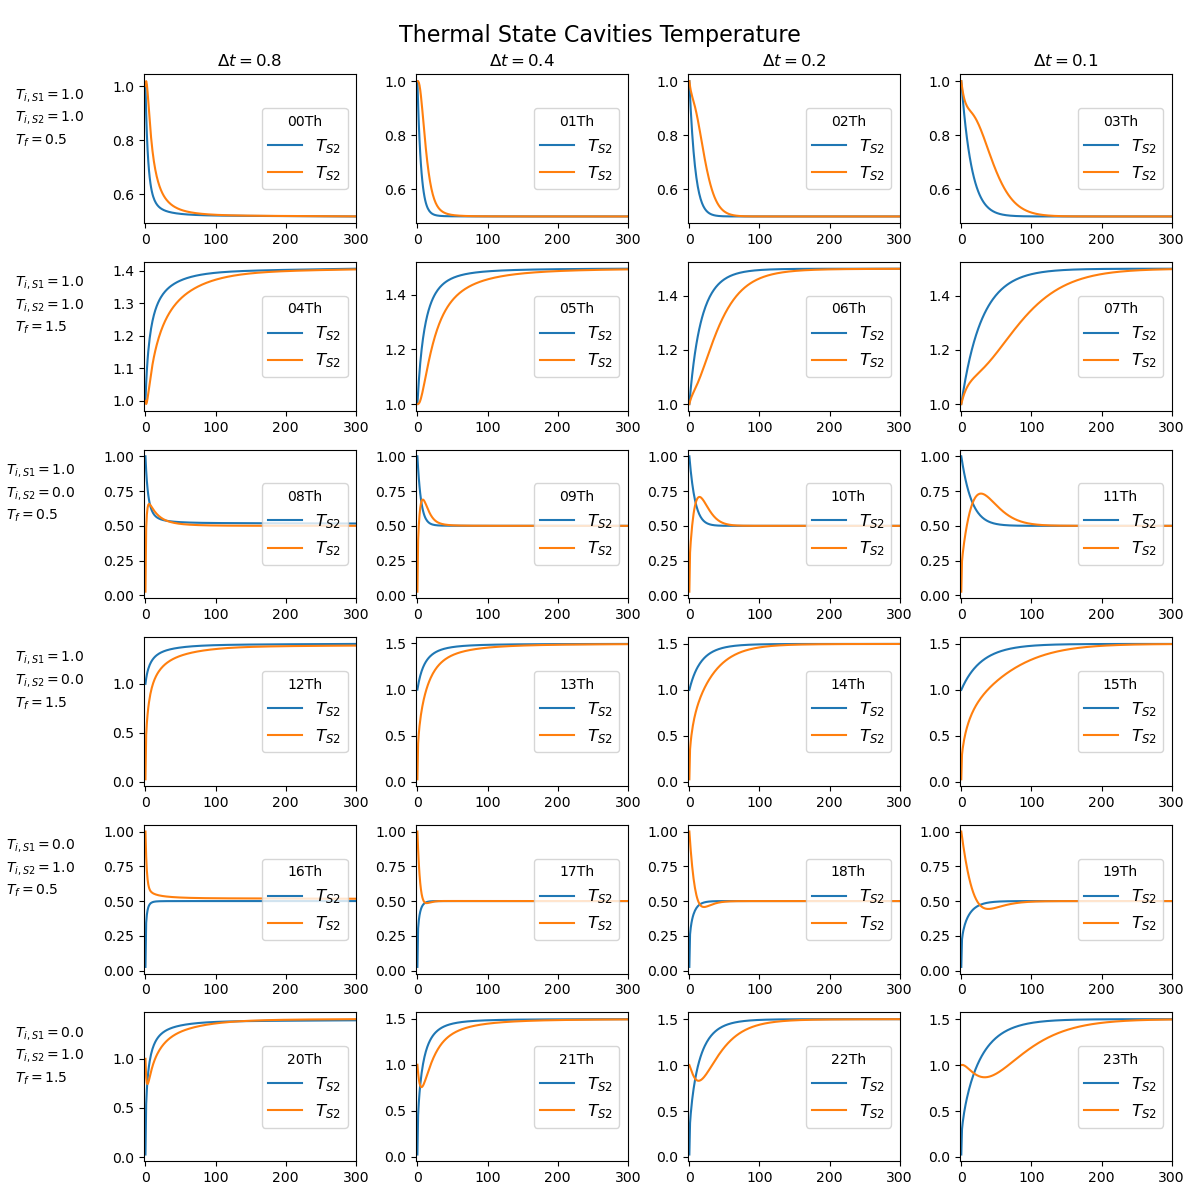

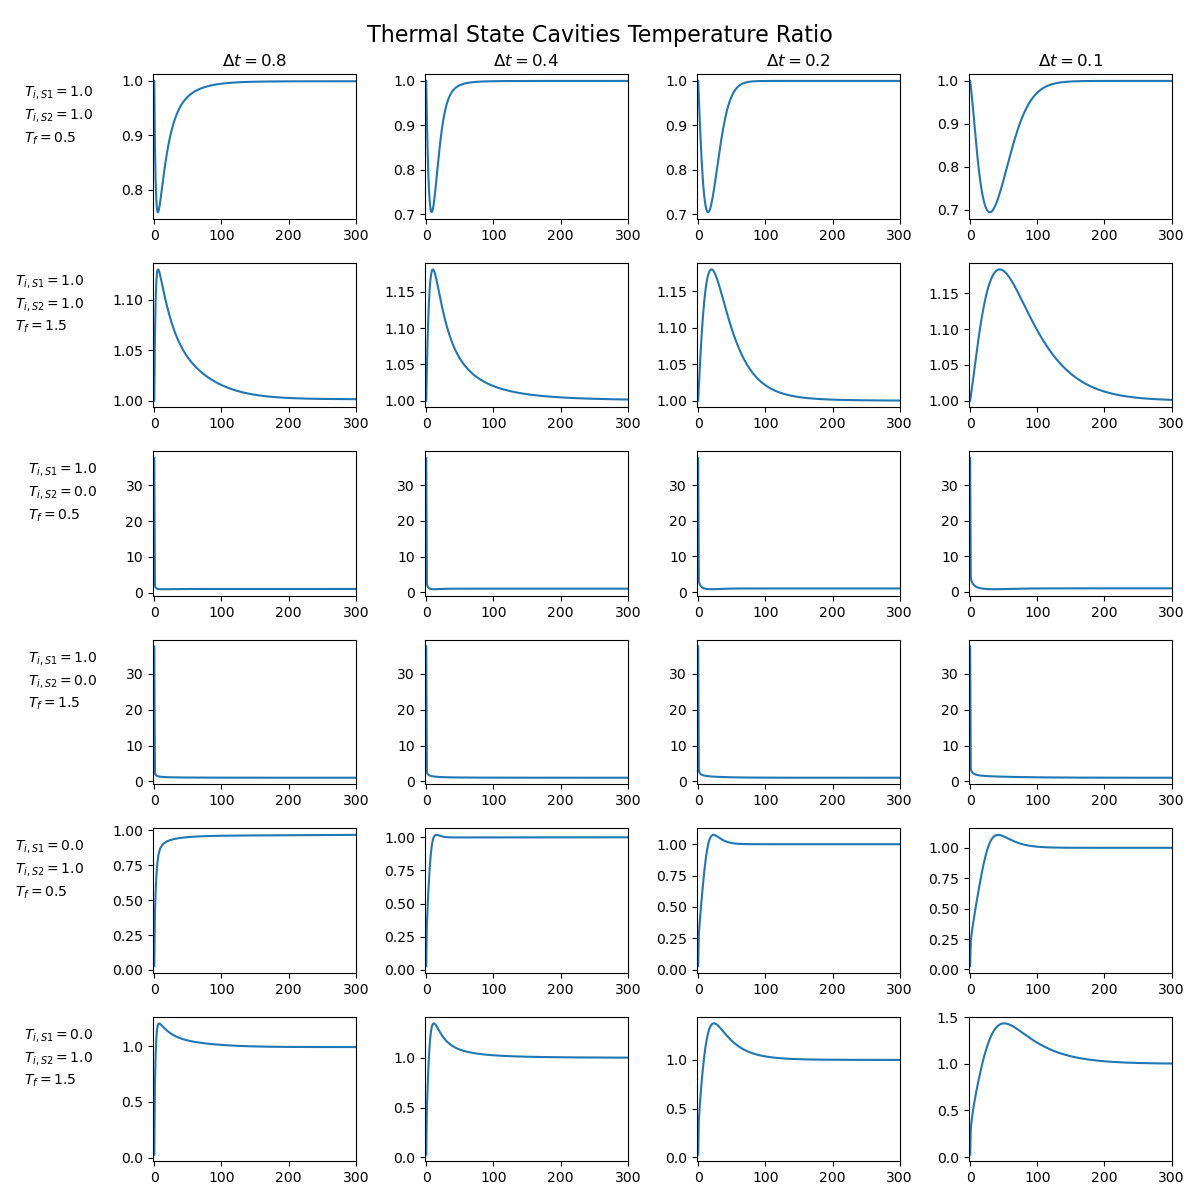

In [76]:
# Reset pyplot figures 
plt.close('all')

make_plots(grid_thermal, 'Thermal', figsize=(12, 12))

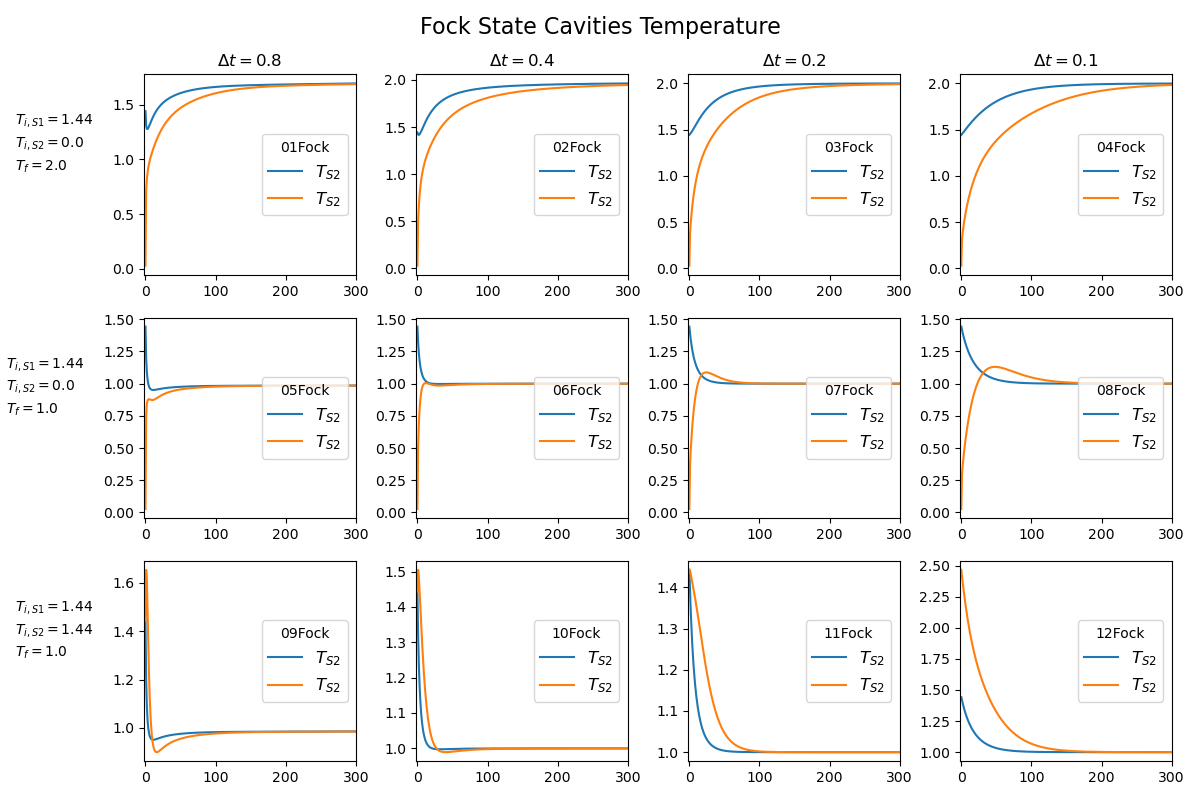

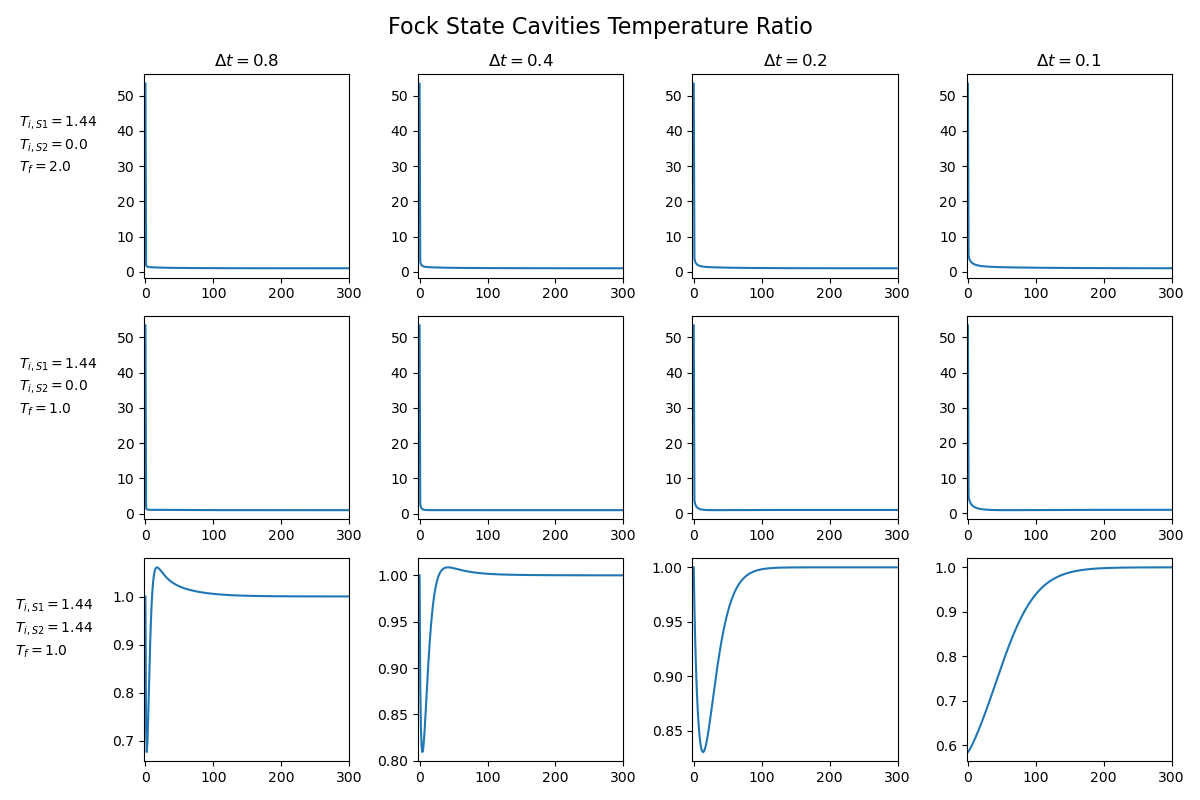

In [77]:
make_plots(grid_fock, 'Fock', figsize=(12, 8))

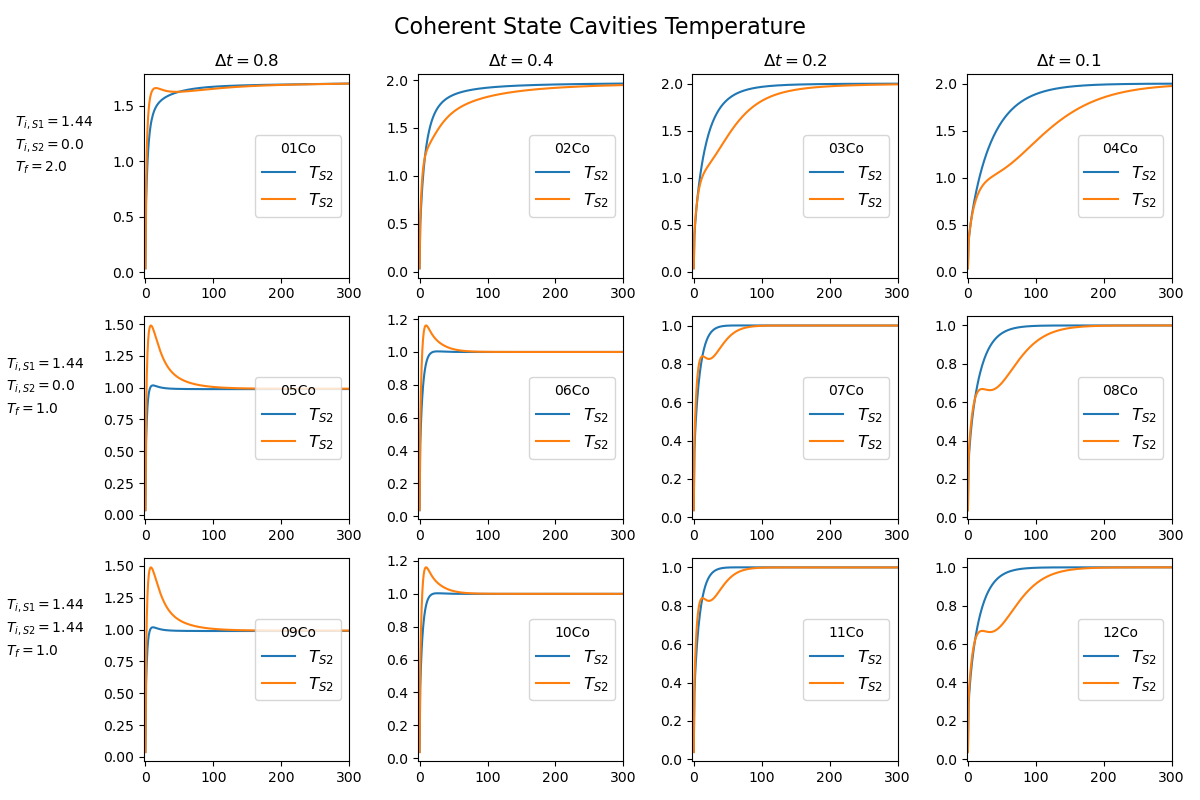

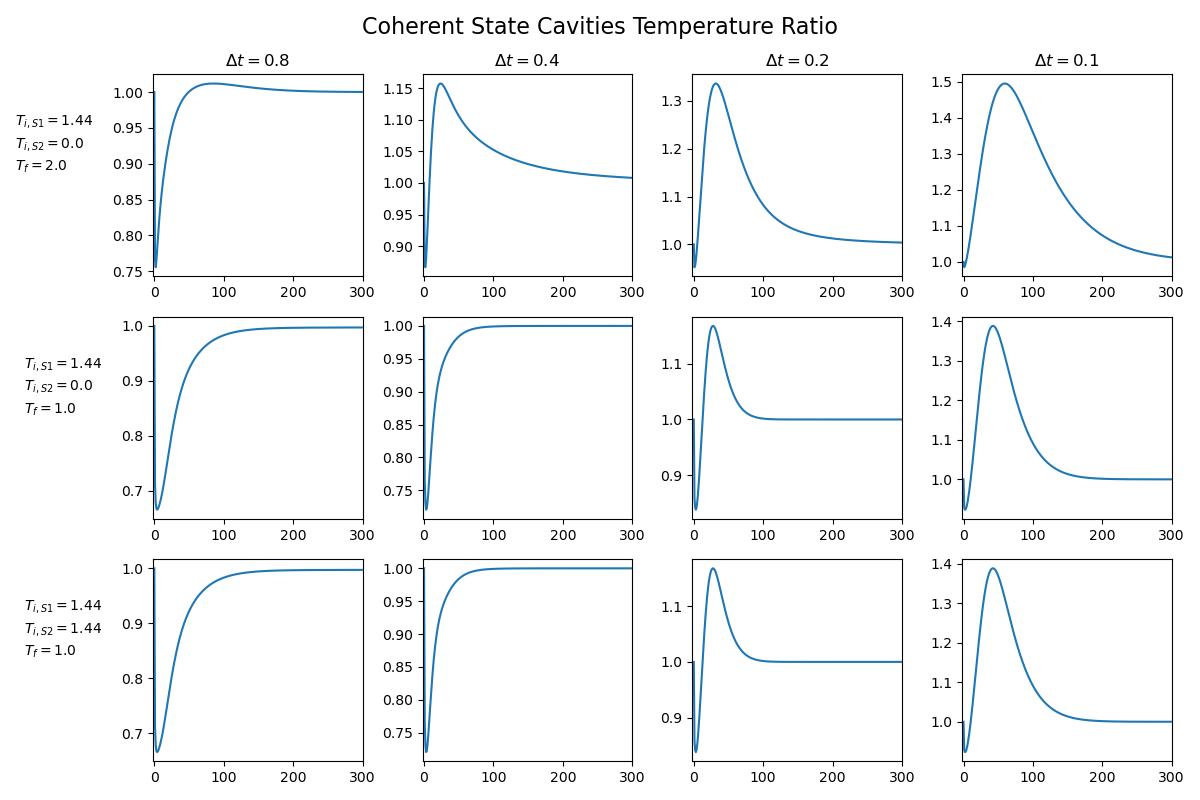

In [78]:
make_plots(grid_coherent, 'Coherent', figsize=(12, 8))

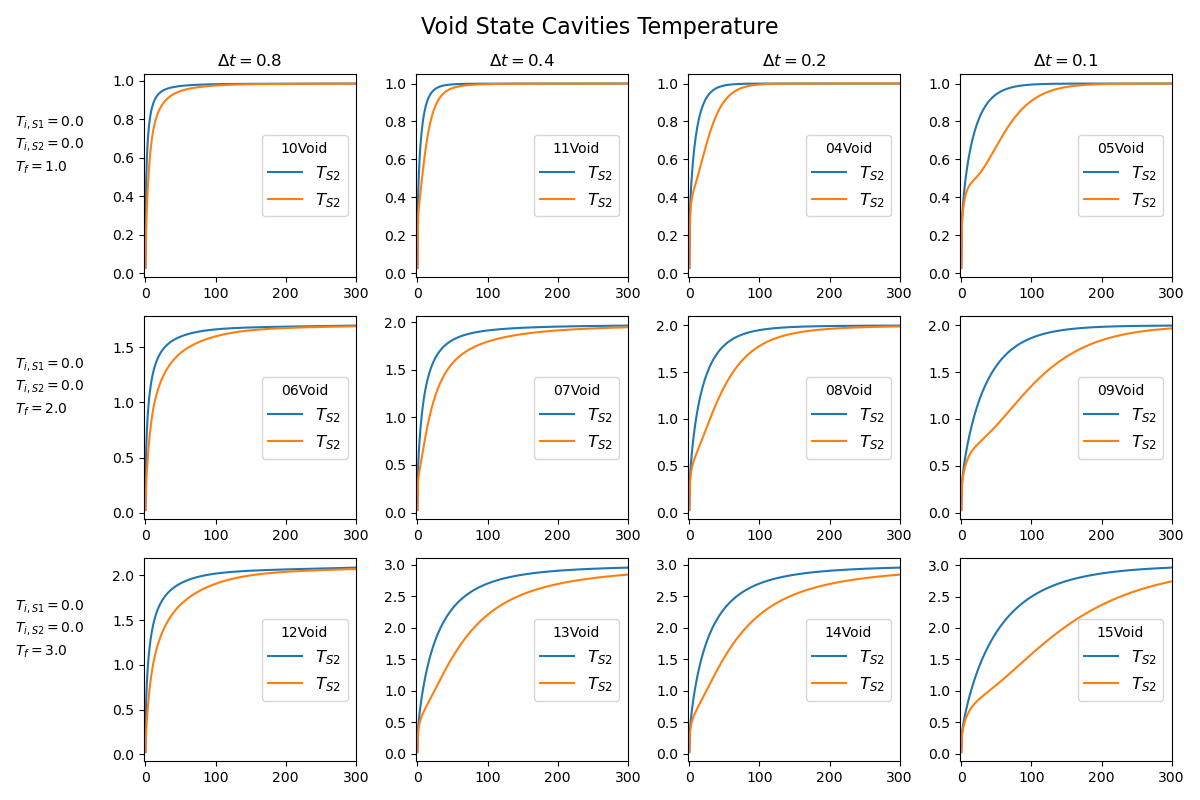

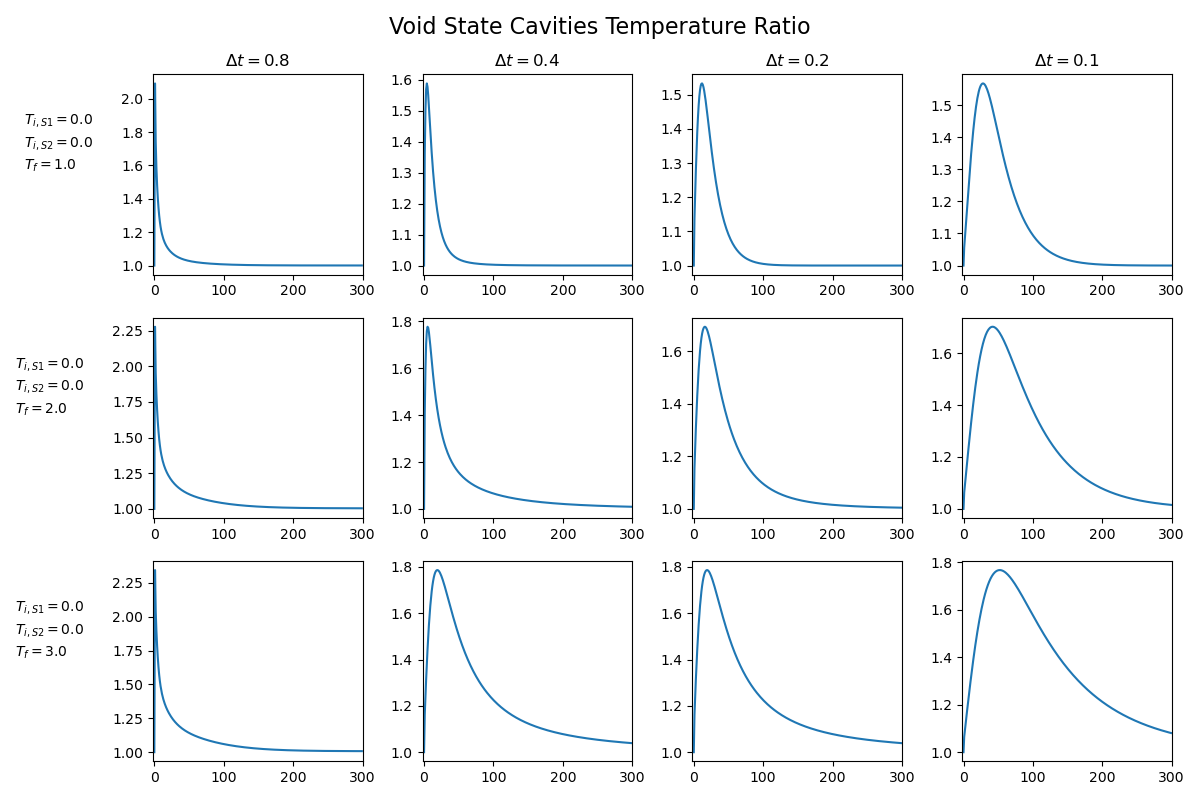

In [79]:
make_plots(grid_void, 'Void', figsize=(12, 8))

In [9]:
metadata


dimensions                      35
timedelta                      0.1
max_timesteps                  300
partial                          0
alpha                     0.513583
phi                    1.570796327
Ti_1                           0.0
Ti_2                           0.0
Tf                             3.0
omega                          1.0
state                      thermal
n1                             0.0
n2                             0.0
exact                        False
machine                     Legion
note             Final giant table
code                           NaN
Name: 15Void, dtype: object